In [ ]:
import os
import dotenv
from langchain_community.embeddings import DashScopeEmbeddings
from langchain_community.llms import Tongyi
dotenv.load_dotenv()

# 初始化大语言模型
DASHSCOPE_API_KEY = os.getenv("DASHSCOPE_API_KEY")
llm = Tongyi(
    model_name="qwen-max", 
    dashscope_api_key=DASHSCOPE_API_KEY
)

# 创建嵌入模型
embeddings = DashScopeEmbeddings(
    model="text-embedding-v1",
    dashscope_api_key=DASHSCOPE_API_KEY
)

In [36]:
from langchain.prompts.loading import load_prompt
prompt_generate = load_prompt(path="prompts_template_generate.json", encoding='utf-8')
prompt_agent = load_prompt(path="prompts_template_agent.json", encoding='utf-8')
prompt_grade = load_prompt(path="prompts_template_grade.json", encoding='utf-8')
prompt_rewrite = load_prompt(path="prompts_template_rewrite.json", encoding='utf-8')

In [37]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_core.messages import HumanMessage, AIMessage
from langchain_core.tools import tool
from langchain_chroma import Chroma

# 定义 State
class State(TypedDict):
    # 状态变量 messages 类型是 list，更新方式是 add_messages
    # add_messages 是内置的一个方法，将新的消息列表追加在原列表后面
    messages: Annotated[list, add_messages]
    contexts: list
    messages_update: bool
    router_after_superagent: str
    router_after_grade:str
    times_rewrite: int
    router_after_rewrite: str

In [38]:
# from langchain.tools.retriever import create_retriever_tool
# def get_tools(llm_embedding):
#     vector_store = Chroma(
#         collection_name="health_docs",
#         embedding_function=llm_embedding,
#         persist_directory="./chroma_db",  # Where to save data locally, remove if not necessary
#     )
#     retriever = vector_store.as_retriever(search_kwargs={"k": 6})
#     retriever_tool = create_retriever_tool(
#         retriever,
#         name="retrieve",
#         description="这是健康档案查询工具，搜索并返回有关用户的健康档案信息。"
#     )
#     @tool
#     def multiply(a: float, b: float) -> float:
#         """这是计算两个数的乘积的工具，返回最终的计算结果"""
#         return a * b
#     return [retriever_tool, multiply]

# tools = get_tools(embeddings)

vector_store = Chroma(
    collection_name="health_docs",
    embedding_function=embeddings,
    persist_directory="./chroma_db",  # Where to save data locally, remove if not necessary
)
vector_retriever = vector_store.as_retriever(search_kwargs={"k": 6})

In [39]:
def super_agent(state: State):
    print(">>> Agent Super")
    user_input = state["messages"][-1]
    message_input = prompt_agent.invoke({"question": user_input}).text
    response = llm.with_config({"temperature": 0}).invoke(message_input)
    types_res = response
    print(types_res)
    return {"router_after_superagent": types_res, "messages_update":False}

def retrieval(state: State):
    cur_message = state['messages'][-1]
    user_query = cur_message.content
    docs = vector_retriever.invoke(user_query)
    contexts = [doc.page_content for doc in docs]
    ragas_contexts.append(contexts)
    return {"contexts": contexts, "messages_update":False}

def grade_docs(state: State):
    print(">>> grade docments")
    user_query = state['messages'][-1]
    context = state["contexts"]
    message_input = prompt_grade.invoke({"question": user_query,"context": context}).text
    response = llm.with_config({"temperature": 0}).invoke(message_input)
    print(response)
    return {"router_after_grade": response, "messages_update":False}

def rewrite(state: State):
    print(">>> rewrite question")
    tr = state['times_rewrite']
    if tr > 3:
        return {"router_after_rewrite": "done"}
    user_query = state['messages'][-1]
    history = state["messages"]
    print(f"*********&&&&&&history:\n{history}")
    message_input = prompt_rewrite.invoke({"question": user_query,"history": history}).text
    response = llm.with_config({"temperature": 0}).invoke(message_input)
    return {"router_after_rewrite": "super_agent", 
            "messages":[HumanMessage(content=response)], 
            "times_rewrite": tr+1,
            "messages_update":True}

def generate(state: State):
    user_query = state['messages'][-1].content
    message_input = prompt_generate.invoke({"question": user_query,"context": state['contexts']}).text
    response = llm.with_config({"temperature": 0}).invoke(message_input)
    ragas_answers.append(response)
    return {"messages": [AIMessage(content=response)], "messages_update":True}

In [40]:
# 条件路由
def router_after_superagent(state: State):
    if state["router_after_superagent"] == "retrieve":
        return "retrieval"
    elif state["router_after_superagent"] == "rewrite":
        return "rewrite"
    elif state["router_after_superagent"] == "done":
        return END

def router_after_grade(state: State):
    if state["router_after_grade"] == "yes":
        return "generate"
    elif state["router_after_grade"] == "no":
        return "rewrite"

graph_builder = StateGraph(State)
graph_builder.add_node("super_agent", super_agent)
graph_builder.add_node("retrieval", retrieval)
graph_builder.add_node("generate", generate)
graph_builder.add_node("rewrite", rewrite)
graph_builder.add_node("grade_docs", grade_docs)

graph_builder.add_edge(START, "super_agent")
graph_builder.add_conditional_edges("super_agent", router_after_superagent,
                                    ["retrieval", "rewrite", END])
graph_builder.add_edge("retrieval", "grade_docs")
graph_builder.add_conditional_edges("grade_docs", router_after_grade,
                                    ["generate", "rewrite"])
graph_builder.add_edge("rewrite", "super_agent")
graph_builder.add_edge("generate", END)

graph = graph_builder.compile()

def stream_graph_updates(user_input: str):
    input_message = {"messages": [HumanMessage(content=user_input)], "messages_update":True, "times_rewrite":0}
    for event in graph.stream(input_message, stream_mode="values"):
        if event["messages_update"]:
            last_message = event["messages"][-1]
            last_message.pretty_print()

In [ ]:
# from IPython.display import Image, display
# from langchain_core.runnables.graph import MermaidDrawMethod
# # 可视化展示这个工作流
# try:
#     display(Image(data=graph.get_graph().draw_mermaid_png()))
# except Exception as e:
#     print(e)

: 

In [41]:
query = ["什么是TSGR", "它有哪些模块"]
for q in query:
    stream_graph_updates(q)

================================ Human Message =================================

什么是TSGR
>>> Agent Super


AttributeError: 'OpenAI' object has no attribute 'with_config'

# 质量评估

In [7]:
from datasets import Dataset
import json

questions, ground_truths = [], []
with open("QApairs.json", 'r', encoding='utf-8') as f:
    data = json.load(f)
for item in data['questions']:
    questions.append(item['question'])
    ground_truths.append(item['answer'])

# print(questions, ground_truths)

In [ ]:
import time

start = time.time()
ragas_answers, ragas_contexts = [], []
len_ragas_answers, len_ragas_contexts = 0, 0
for q in questions:
    stream_graph_updates(q)
    if len(ragas_answers) == len_ragas_answers:
        ragas_answers.append('No answer')
    if len(ragas_contexts) == len_ragas_contexts:
        ragas_contexts.append(['No contexts'])
    len_ragas_answers += 1
    len_ragas_contexts += 1
end_time = time.time()

================================ Human Message =================================

fMRI的主要应用领域有哪些？
>>> Agent Super
retrieve
>>> grade docments
yes
================================== Ai Message ==================================

fMRI（功能性磁共振成像）的主要应用领域包括：

1. **认知神经科学**：fMRI被广泛用于研究大脑在感知、记忆、语言、情绪和决策等认知过程中的功能活动，显著推动了对健康和疾病状态下大脑功能的理解。

2. **临床医学**：在神经系统疾病的诊断和研究中具有重要价值，如阿尔茨海默病、抑郁症、精神分裂症、癫痫等，帮助识别异常脑区和功能连接。

3. **静息态fMRI（rs-fMRI）**：由于不需要受试者主动参与任务，rs-fMRI被用于研究大脑的默认网络和功能连接，广泛应用于临床和基础研究。

4. **药物成瘾研究**：用于探究成瘾行为相关的脑机制，评估干预效果。

5. **神经市场营销（Neuromarketing）**：通过监测消费者对广告或产品的脑部反应，研究消费决策的心理机制。

6. **政治心理学**：研究个体在面对政治信息或人物时的大脑反应，探索政治态度和决策的神经基础。

7. **动物研究与转化医学**：fMRI也被应用于小鼠、大鼠、非人灵长类、狗、猫等动物，推动从动物模型到人类疾病的转化研究。

这些应用得益于fMRI高空间分辨率和非侵入性的特点，使其成为研究大脑功能的重要工具。
================================ Human Message =================================

fMRI实验设计中常见的类型有哪些？
>>> Agent Super
retrieve
>>> grade docments
yes
================================== Ai Message ==================================

fMRI实验设计中常见的类型主要包括以下两种：

1.

In [24]:
print(end_time-start)
## 30个问题，329.6936116218567s

ragas_answers[28] = 'No answer'
print(ragas_answers[28])

317.06063413619995
No answer


In [25]:
# To dict
data = {
    "user_input": questions,
    "response": ragas_answers,
    "retrieved_contexts": ragas_contexts,
    "reference": ground_truths
}
 
# Convert dict to dataset
dataset = Dataset.from_dict(data)
dataset

Dataset({
    features: ['user_input', 'response', 'retrieved_contexts', 'reference'],
    num_rows: 30
})

In [26]:
# 评测结果
from ragas import evaluate
from ragas.metrics import (
    faithfulness,
    answer_relevancy,
    context_recall,
    context_precision,
)
 
result = evaluate(
    dataset = dataset, 
    metrics=[
        context_precision,
        context_recall,
        faithfulness,
        answer_relevancy,
    ],
    llm=llm,
    embeddings=embeddings
)
 
df = result.to_pandas()
df

Evaluating:  87%|████████▋ | 104/120 [02:20<00:23,  1.45s/it]Prompt fix_output_format failed to parse output: The output parser failed to parse the output including retries.
Prompt fix_output_format failed to parse output: The output parser failed to parse the output including retries.
Prompt fix_output_format failed to parse output: The output parser failed to parse the output including retries.
Prompt response_relevance_prompt failed to parse output: The output parser failed to parse the output including retries.
Exception raised in Job[115]: RagasOutputParserException(The output parser failed to parse the output including retries.)
Evaluating: 100%|██████████| 120/120 [03:05<00:00,  1.55s/it]


,user_input,retrieved_contexts,response,reference,context_precision,context_recall,faithfulness,answer_relevancy
0,fMRI的主要应用领域有哪些？,"[(\nGreicius and Menon, 2004; Anticevic et al....",fMRI（功能性磁共振成像）的主要应用领域包括：\n\n1. **认知神经科学**：fMRI...,fMRI在认知神经科学、临床神经影像学、静息态功能连接分析、实时神经反馈和脑机接口等领域有广...,0.000000,0.000000,0.705882,0.788788
1,fMRI实验设计中常见的类型有哪些？,[parameters can signiﬁcantly improve the study...,fMRI实验设计中常见的类型主要包括以下两种：\n\n1. **静息态fMRI（Restin...,fMRI实验设计主要分为静息态设计和任务态设计。任务态设计又包括区块设计（block des...,0.333333,1.000000,0.600000,0.948527
2,fMRI数据采集中最常见的伪影有哪些？,[Soares et al. A Hitchhiker’s Guide to fMRI\na...,fMRI数据采集中最常见的伪影包括以下几类：\n\n1. **与脉冲序列和硬件相关的伪影**...,fMRI数据采集中的主要伪影包括空间畸变（spatial distortions）、信号丢失...,1.000000,1.000000,0.636364,0.952402
3,fMRI预处理的主要步骤包括哪些？,[Soares et al. A Hitchhiker’s Guide to fMRI\nT...,fMRI预处理的主要步骤通常包括以下内容（根据上下文中的TABLE 3及描述总结）：\n\n...,fMRI预处理的主要步骤包括：\n1. 数据转换（DICOM到NIfTI格式）\n2. 初始...,1.000000,0.875000,0.960000,0.764879
4,任务态fMRI分析中最常用的方法是什么？,"[assist with this choice, we herein present a ...",任务态fMRI分析中最常用的方法是统计参数映射（Statistical Parametric...,任务态fMRI分析最常用的方法是基于一般线性模型（GLM）的统计参数映射（Statistic...,0.450000,0.500000,0.500000,0.855052
5,静息态fMRI分析的常用方法有哪些？,"[to task-based and rs-fMRI and, with their hig...","静息态fMRI（resting-state fMRI, rs-fMRI）分析的常用方法包括：...",静息态fMRI分析的常用方法包括：\n1. 种子点相关分析（seed-based corre...,0.000000,0.142857,0.172414,0.614261
6,fMRI研究中常用的统计显著性校正方法有哪些？,"[Winkler et al.,\n2014) and SnPM ( Nichols and...",在fMRI研究中，由于需要对大量体素（voxel）进行多重比较，因此必须采用统计显著性校正方...,fMRI研究中常用的统计显著性校正方法包括：\n1. 基于体素的阈值法：家族误差率（FWER...,0.000000,0.666667,0.634146,0.711125
7,fMRI研究中常见的多模态研究方法有哪些？,[Soares et al. A Hitchhiker’s Guide to fMRI\nF...,在fMRI研究中，常见的多模态研究方法通常结合任务态（task-based）和静息态（res...,fMRI研究中常见的多模态研究方法包括：\n1. 结合结构信息（如扩散数据、体积数据、皮层厚...,0.000000,0.000000,0.464286,0.712869
8,fMRI研究中如何解决多重比较问题？,[ges125/fMRI/RSFgen.html) and the fMRI Simulat...,在fMRI研究中，由于需要对全脑成千上万个体素（voxels）进行统计检验，多重比较问题会导...,fMRI研究中解决多重比较问题的方法包括：\n1. 使用更严格的显著性阈值（如p < 0.0...,0.000000,0.000000,0.147059,0.833971
9,fMRI研究中常见的软件工具有哪些？,[Soares et al. A Hitchhiker’s Guide to fMRI\nT...,在fMRI研究中，常见的软件工具包括：\n\n1. **AFNI (Analysis of ...,fMRI研究中常见的软件工具包括：\n1. SPM（Statistical Parametr...,0.166667,0.545455,0.763636,0.713239


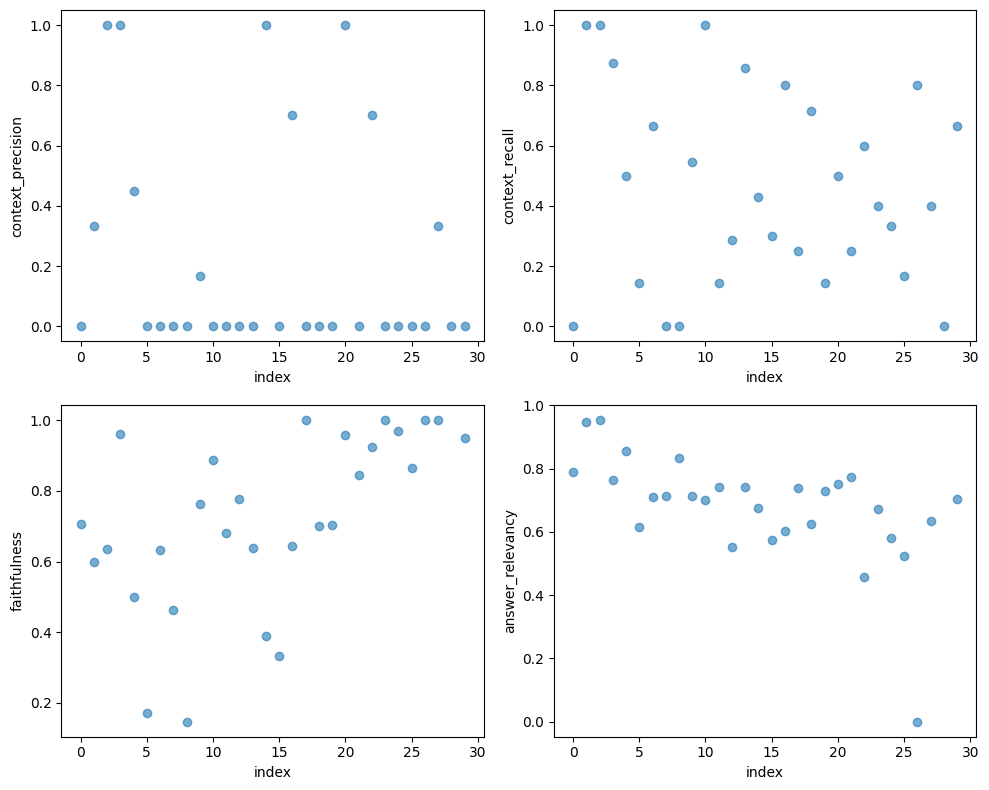

In [33]:
import matplotlib.pyplot as plt

cols_to_plot = ['context_precision', 'context_recall', 'faithfulness', 'answer_relevancy']
# 创建2x2的子图布局
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
# fig.suptitle('', fontsize=16)

# 绘制每个子图
for col, ax in zip(cols_to_plot, axes.flat):
    ax.scatter(range(len(df)), df[col], alpha=0.6)
    ax.set_xlabel('index')
    ax.set_ylabel(f'{col}')

plt.tight_layout()
plt.show()